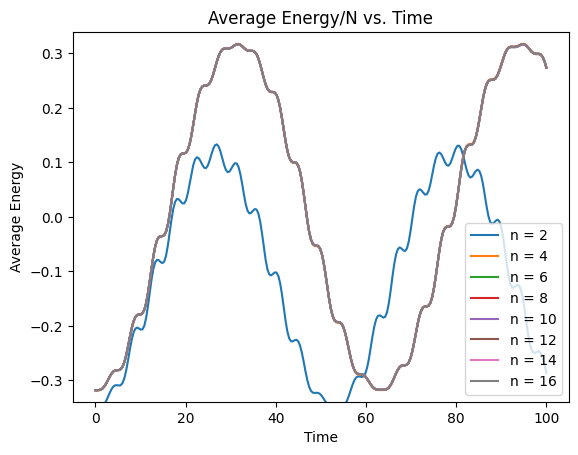

In [1]:
from scipy.sparse import csr_matrix
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from quantumScarsCheck import *
from quantumScarsPlotting import *
from quantumScarFunctions import *

max_N = 16 # IDDEN MAKE SURE TO MAKE THIS AN EVEN NUMBER <----------------------------------------------------------
nlist = np.linspace(2, max_N, int(max_N/2))
tlist = np.linspace(0, 100, 250)
expectationEnergy = []

for n in nlist:
    N = int(n)
    basisList = binNoConsecOnesEfficient(N)
    for basis in basisList:
        if basis[0] == '1' and basis[-1] == '1':
            basisList.remove(basis)
    #print(basisList)
        
    basisMap = {bitStr: i for i, bitStr in enumerate(basisList)}
    # print(basisMap)
    basisLen = len(basisList)
    flippedList = []
    ohms = 1.0

    rowBare = []
    columnBare = []

    rowFactor = []
    columnFactor = []

    # flip bit hashmap
    flipMap = {'0': '1', '1': '0'}

    # sigma z op hashmap
    sigzMap = {'0': '-1', '1': '1'}

    # list of ints for Hamiltonian
    numList = []

    # -------------------------------
    #
    # create the bare PXP hamiltonian
    #
    # -------------------------------
    # the padded variables are not padded
    for i in range(basisLen):

        # add padding so that search doesnt go out of range
        paddedBitStr = basisList[i][-1] + basisList[i] + basisList[i][0]
        copyBit = list(paddedBitStr)

        # apply the sum of r P_r-1 * sigma_x * P_r+1 operator
        for j in range(1, N+1):
            
            if paddedBitStr[j-1] == '0' and paddedBitStr[j+1] == '0':
                copyBit[j] = flipMap[paddedBitStr[j]]
                flippedList.append(''.join(copyBit)[1:-1])
                copyBit = list(paddedBitStr)
            
        # adds row and column values for the sparse matrix
        for k in range(len(flippedList)):
            rowBare.append(basisMap[flippedList[k]])
            columnBare.append(i)
            
        flippedList.clear()

    # -------------------------------
    #
    # create the sigma Z PXP hamiltonian perturbation
    #
    # -------------------------------

    # print(basisList)
    # print()

    for i in range(basisLen):

        # add padding so that search doesnt go out of range
        paddedBitStr = basisList[i][-2] + basisList[i][-1] + basisList[i] + basisList[i][0] + basisList[i][1]
        copyBit = list(paddedBitStr)
        factor = 1

        # apply the PXP operator
        for j in range(2, N+2):
            
            if (paddedBitStr[j-1] == '0') and (paddedBitStr[j+1] == '0'):
                copyBit[j] = flipMap[paddedBitStr[j]]

                # apply sigmaZ_r-2 + sigmaZ_r+2
                r_neg2 = int(sigzMap[paddedBitStr[j-2]])
                r_pos2 = int(sigzMap[paddedBitStr[j+2]])
                factor = r_neg2 + r_pos2
                numList.append(factor)

                flippedList.append(''.join(copyBit)[2:-2])
                copyBit = list(paddedBitStr)
            
        # print(flippedList)

        # adds row and column values for the sparse matrix
        for k in range(len(flippedList)):
            rowFactor.append(basisMap[flippedList[k]])
            columnFactor.append(i)
            
        flippedList.clear()

    # list of ones for the sparse matrix
    onesList = np.ones(len(rowBare), dtype=int)

    # create the sparse matrix and turn it into a Qobj
    sparseBareHamiltonian = csr_matrix((onesList, (rowBare, columnBare)), shape=[basisLen, basisLen])
    matrixBareHamiltonian = sparseBareHamiltonian.toarray()

    sparseFactoredHamiltonian = csr_matrix((numList, (rowFactor, columnFactor)), shape=[basisLen, basisLen])
    matrixFactoredHamiltonian = sparseFactoredHamiltonian.toarray()

    H0 = (ohms / 2 * sparseBareHamiltonian) + (-0.026 * ohms * sparseFactoredHamiltonian)

    # print()
    # print(H0)

    H0 = qt.Qobj(H0)

    # -------------------------------
    #
    # states and evolutions set ups
    #
    # -------------------------------

    # diagonalize the sparse matrix
    eigenvalues, eigenstates = H0.eigenstates()

    # initial state
    z2_str = z2_initial(N)
    #print(z2_str)
    z2_index = basisMap[z2_str]
    psi0 = qt.basis(basisLen, z2_index)

    # time evolution of sparse matrix
    evolState = qt.sesolve(H0, psi0, tlist)

    # -------------------------------
    #
    # create the driving hamiltonian
    #
    # -------------------------------

    # create H1 operator for QobjEvo
    copyBasis = basisList
    diagH1 = []

    # switches 0s to -1s and keeps 1s the same for the copyBasis
    # appends to diagH1 the dot product between each bit string and the 0 -> -1 Z2 state
    for i in range(basisLen):

        bitString = list(copyBasis[i])
        bitString = [int(i) for i in bitString]

        z2bitString = list(z2_initial(N))
        z2bitString = 2 * np.array([int(i) for i in z2bitString]) - 1

        diagH1.append(np.dot(2 * np.array(bitString) - 1, z2bitString))

    # rows and columns lists for diagonal positions in H1
    rowH1 = [i for i in range(basisLen)]
    columnH1 = [i for i in range(basisLen)]

    # creates sparse matrix with diagonals as diagH1 list
    H1 = csr_matrix((diagH1, (rowH1, columnH1)), shape=[basisLen, basisLen])
    H1 = qt.Qobj(H1)

    # -------------------------------
    #
    # compare average energy/n qubits
    #
    # -------------------------------

    args = {"A": 0.1, "omega": 0.642570281124498}
    H = qt.QobjEvo([H0, [H1, coeff]], args=args) # drive H0 using H1
    psi_t = qt.sesolve(H, eigenstates[0], tlist) # evolve the ground state through time
    tempExpectation = []

    for states in psi_t.states:

        val = states.dag() * H0 * states
        tempExpectation.append(val.real)

    expectationEnergy.append(np.array(tempExpectation) / N)
        
for n in range(len(nlist)):
    plt.plot(tlist, expectationEnergy[n], label=f"n = {int(nlist[n])}")

plt.xlabel("Time")
plt.ylabel("Average Energy")
plt.title("Average Energy/N vs. Time")
plt.ylim(eigenvalues[0] / (max_N-1), eigenvalues[-1] / (max_N-1))
plt.legend()
plt.show()

    

In [6]:
for i in range(len(expectationEnergy)-1):
    print(np.max(np.array(expectationEnergy[i]) - np.array(expectationEnergy[i+1])))

0.2500415883211087
0.002035904627966628
0.000380878317443184
0.000689309840832486
0.00030305511024514287
0.00030940190202893847
0.00010899581931744784
